In [14]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

colors=sns.color_palette()

## Toss coins

In [2]:
def throw_coin(numb):
    return np.random.choice(['H', 'T'], numb)
throws = throw_coin(40)
print('Throws:',' '.join(throws))
print('Number of Heads:', np.sum(throws == 'H'))
print('probability = Number of Heads/Total Throws:', np.sum(throws == 'H')/40)

Throws: H H T T H T H H T H H H H H H H H T H H T T T H T H H H H H T H T H T T H T H T
Number of Heads: 25
probability = Number of Heads/Total Throws: 0.625


## Simulate Probablity Model for US Election

In [9]:
predmodel = pd.read_csv('predictwise.csv').set_index('States')
predmodel.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


In [5]:
def simulate_model(model ,n):
    simulation = np.random.uniform(size=(51, n))
    obama_votes = (simulation < model.Obama.values.reshape(-1, 1)) * model.Votes.values.reshape(-1, 1)
    return obama_votes.sum(axis = 0)

result = simulate_model(predmodel, 10000)
print((result >= 269).sum())

9965


Plotting the Graph

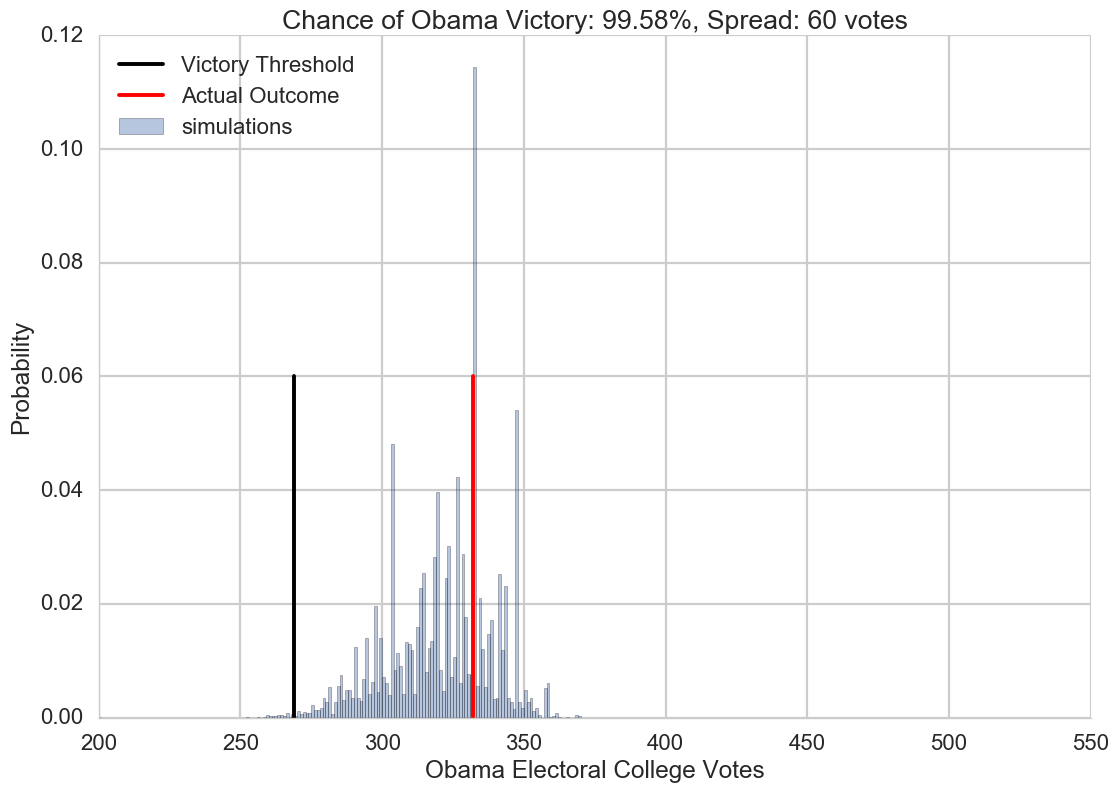

In [129]:
with sns.axes_style('whitegrid'):
    sns.distplot(result, bins = np.arange(200, 538, 1), norm_hist = True, kde = False,
                label = 'simulations')
    plt.axvline(269, 0, .5, color='k', label = 'Victory Threshold')
    plt.axvline(332, 0, .5, color='r', label = 'Actual Outcome')
    q05 = np.percentile(result, 5.)
    q95 = np.percentile(result, 95.)
    sp = int(q95 - q05)
    pwin = (result>=269).mean() * 100
    plt.title('Chance of Obama Victory: %0.2f%%, Spread: %d votes' %(pwin, sp))
    plt.xlabel('Obama Electoral College Votes')
    plt.ylabel('Probability')
    plt.legend(loc='upper left', frameon=False)
    sns.despine()


## CDF curve for Obama Election

In [3]:
CDF = lambda x: np.float(np.sum(result < x))/len(result)

votelist = pd.Series(np.arange(0, 540, 5))
CDF_value = pd.Series([CDF(numb) for numb in votelist])
cdf_df = pd.concat([votelist, CDF_value], axis=1)
type(cdf_df)

NameError: name 'result' is not defined

In [74]:
cdf_df.columns= ['vote', 'prob']

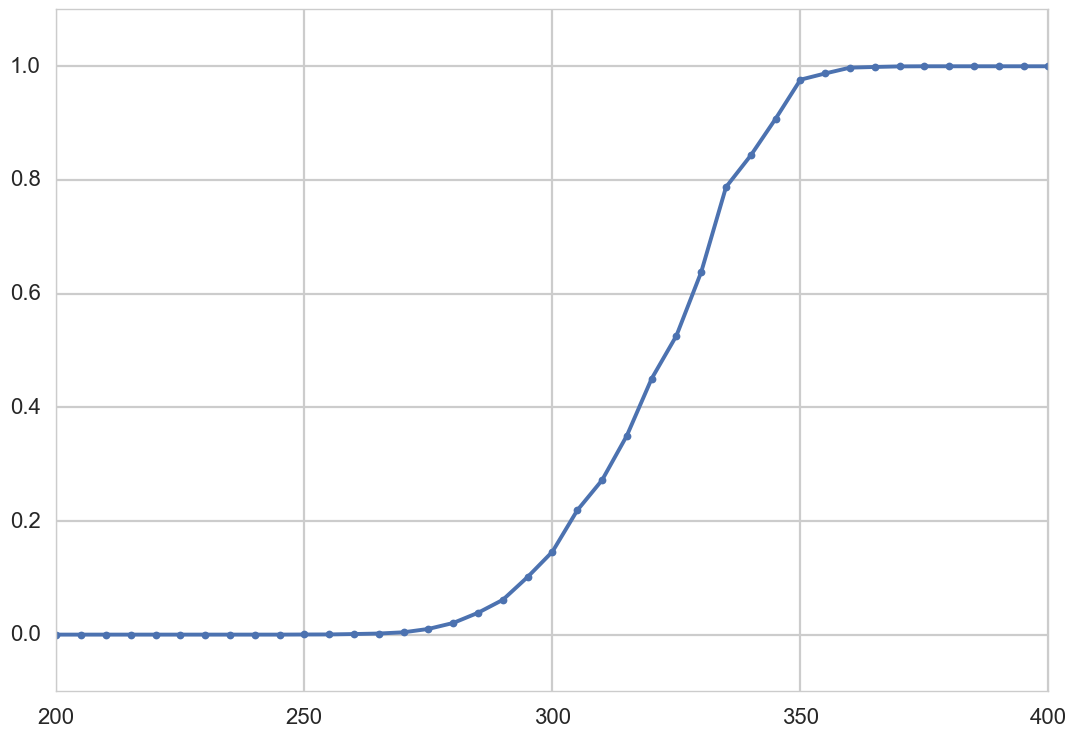

In [78]:
with sns.axes_style('whitegrid'):
    plt.plot(votelist, CDF_value, '.-')
    plt.xlim([200,400])
    plt.ylim([-0.1, 1.1])

### Throw a Coin and Plot it

In [93]:
from scipy.stats.distributions import bernoulli
def throwC(n):
    brv = bernoulli(0.5)
    return brv.rvs(size = n)

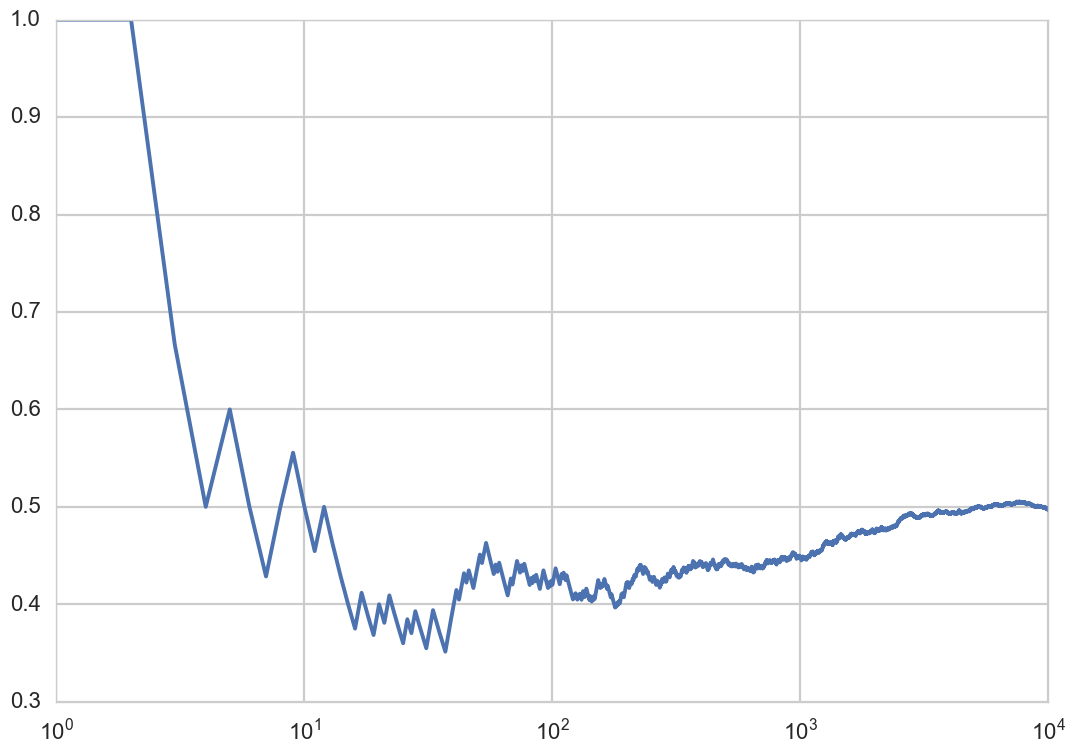

In [99]:
trial = throwC(10000)
num_trial = np.arange(1, 10001, 1)
zeros = np.zeros(10000)
for i in num_trial:
    zeros[i-1] = np.mean(trial[:i])
plt.plot(num_trial, zeros)
plt.xscale('log')

### Data & Models

In [4]:
baby = pd.read_table('babyboom.dat.txt', header=None, sep='\s+', names = ['24hrtime','sex','weight','minutes'])

In [107]:
baby.head()

,24hrtime,sex,weight,minutes
0,5,1,3837,5
1,104,1,3334,64
2,118,2,3554,78
3,155,2,3838,115
4,257,2,3625,177


In [109]:
baby.minutes.mean()

788.7272727272727

In [110]:
baby.corr()

,24hrtime,sex,weight,minutes
24hrtime,1.000000,0.028027,0.075636,0.999840
sex,0.028027,1.000000,0.228751,0.031815
weight,0.075636,0.228751,1.000000,0.079616
minutes,0.999840,0.031815,0.079616,1.000000


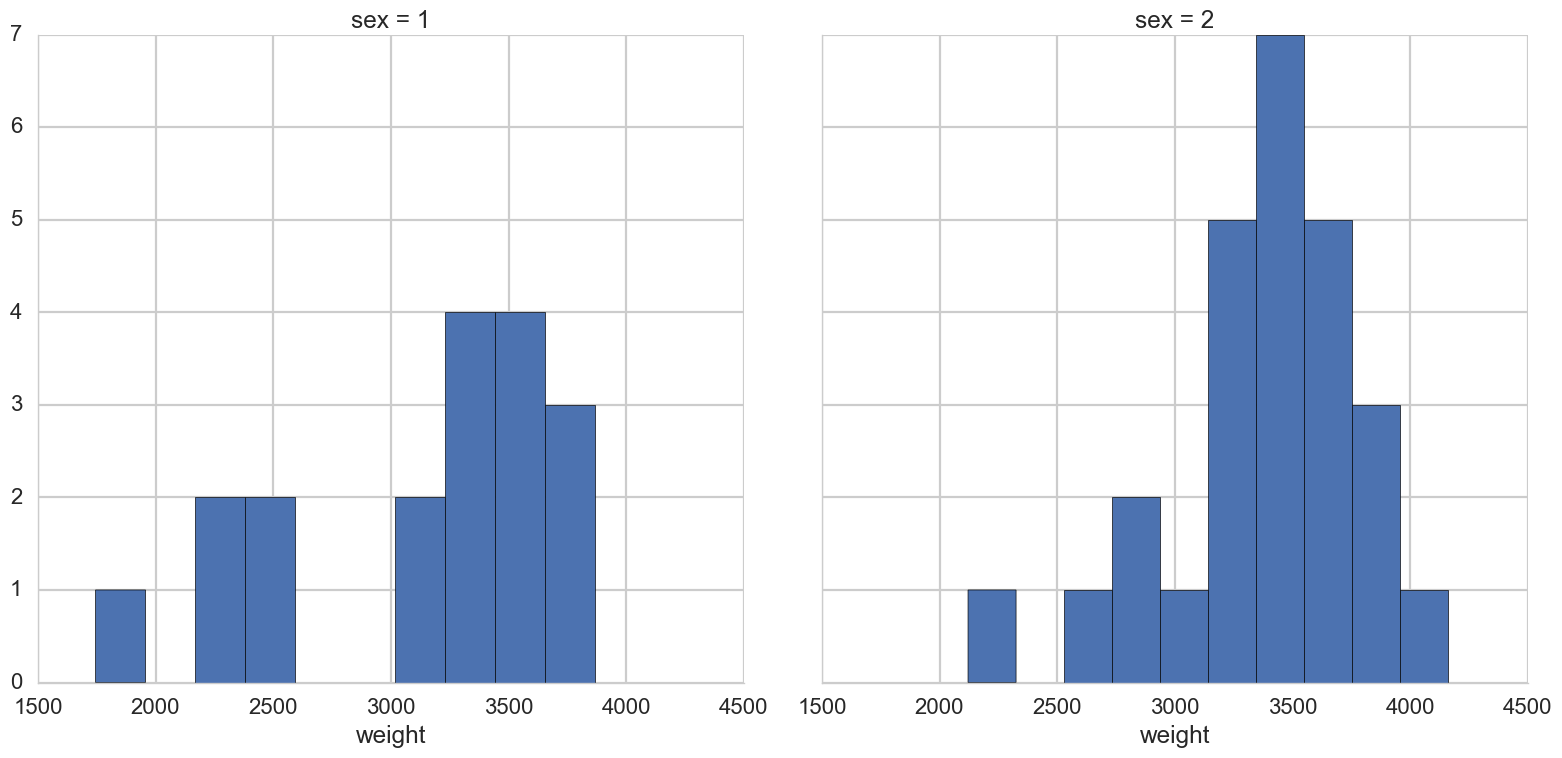

In [112]:
g = sns.FacetGrid(col='sex', data=baby, size=8)
g.map(plt.hist, 'weight')

### Poisson Model for baby birth time

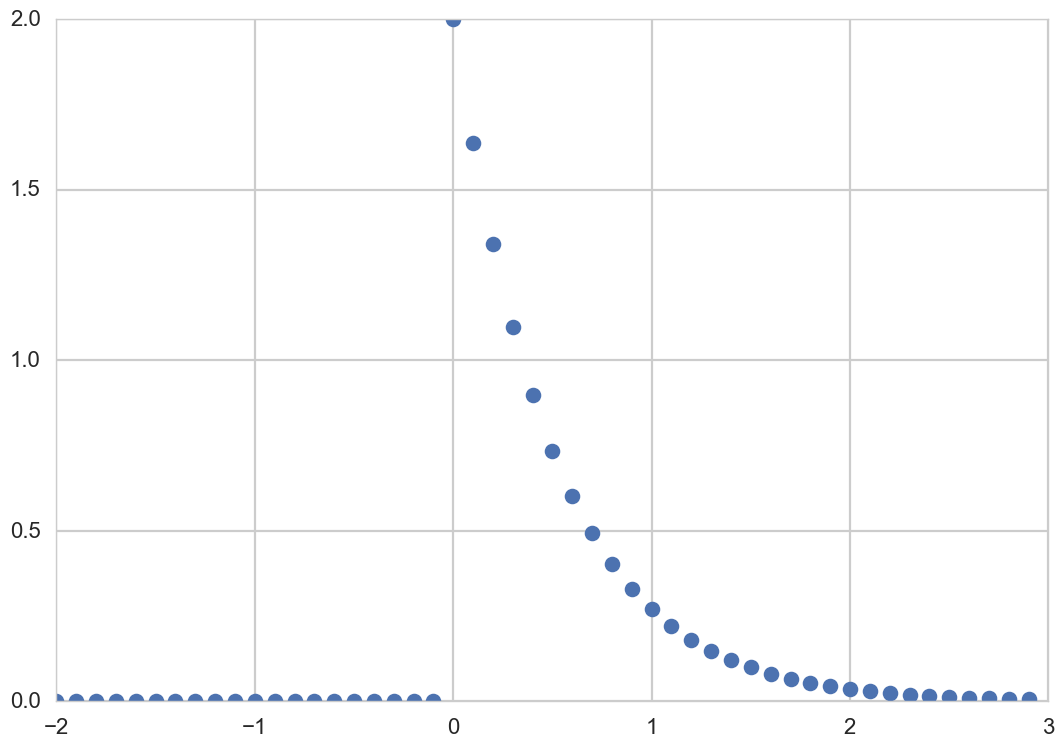

In [78]:
f = lambda x, l: l*np.exp(-l*x)*(x>0)
scale = np.arange(-2,3,0.1)
plt.plot(scale, f(scale, 2), 'o')
plt.figure(figsize=(12,4))

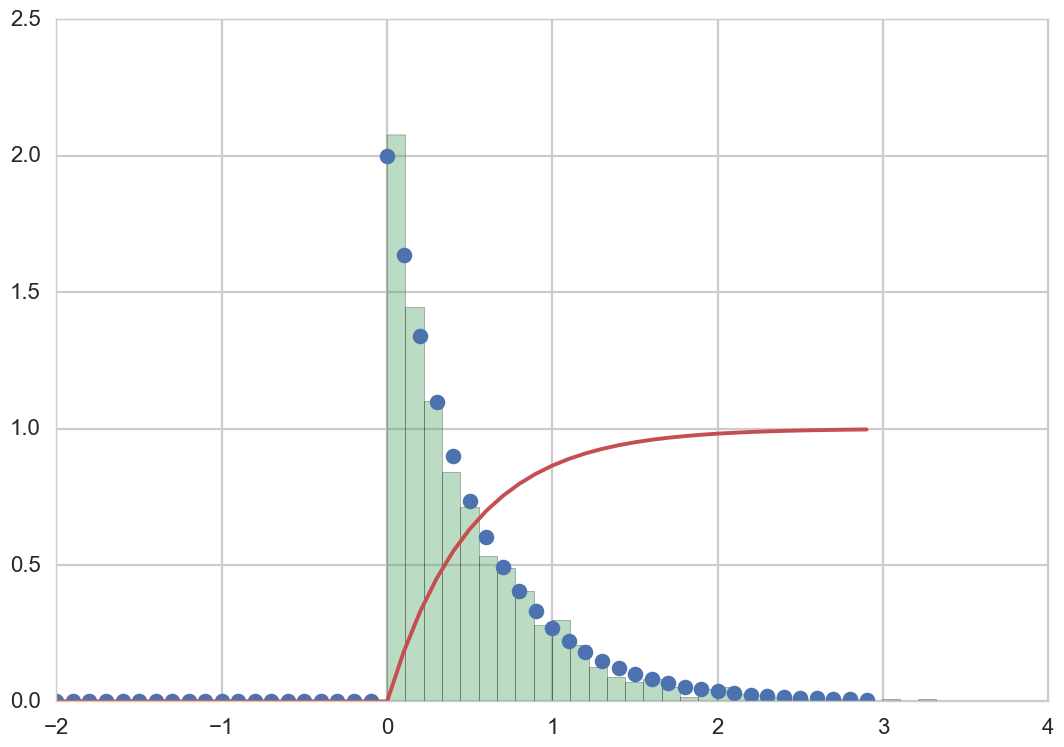

In [79]:
from scipy.stats import expon
plt.plot(scale, expon.pdf(scale, scale = 1./2.), 'o')
plt.hist(expon.rvs(size=1000,scale=1./2.),normed=True,bins=30,alpha=0.4)
plt.plot(scale, expon.cdf(scale, scale=1./2.))

### Distribution of Dataset

(array([ 6.,  9.,  3.,  8.,  4.,  3.,  2.,  3.,  2.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([   1. ,    8.8,   16.6,   24.4,   32.2,   40. ,   47.8,   55.6,
          63.4,   71.2,   79. ,   86.8,   94.6,  102.4,  110.2,  118. ,
         125.8,  133.6,  141.4,  149.2,  157. ]),
 <a list of 20 Patch objects>)

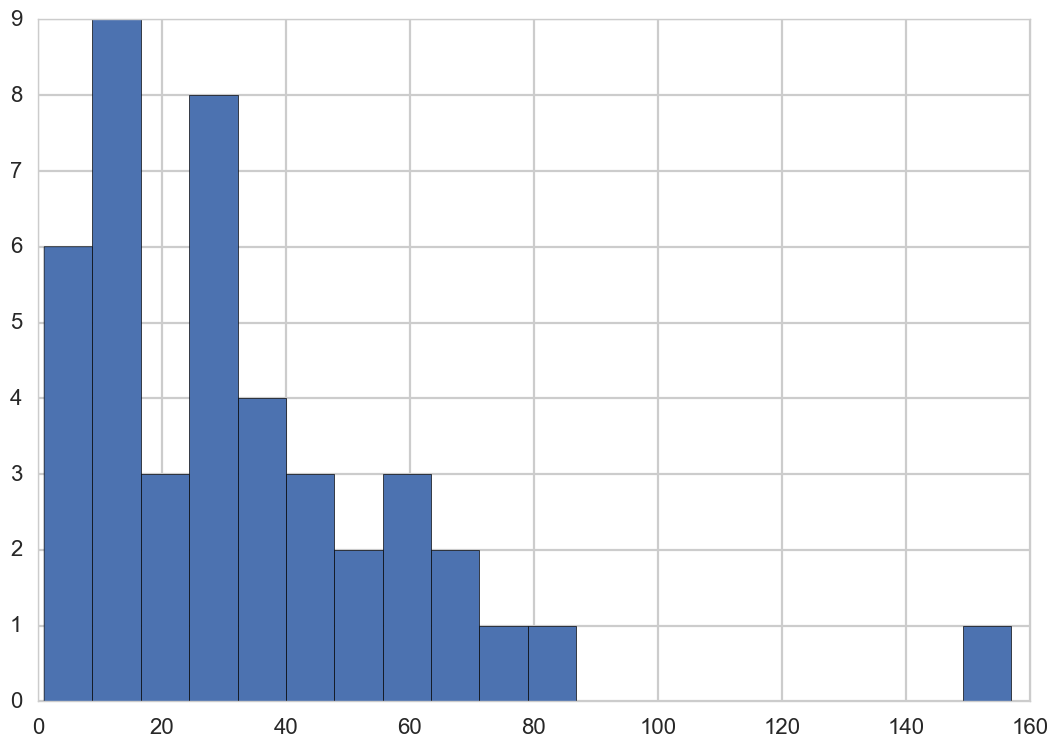

In [80]:
diff = baby.minutes.diff()[1:]
plt.hist(diff, bins=20)

In [150]:
lambda_from_mean = 1./diff.mean()

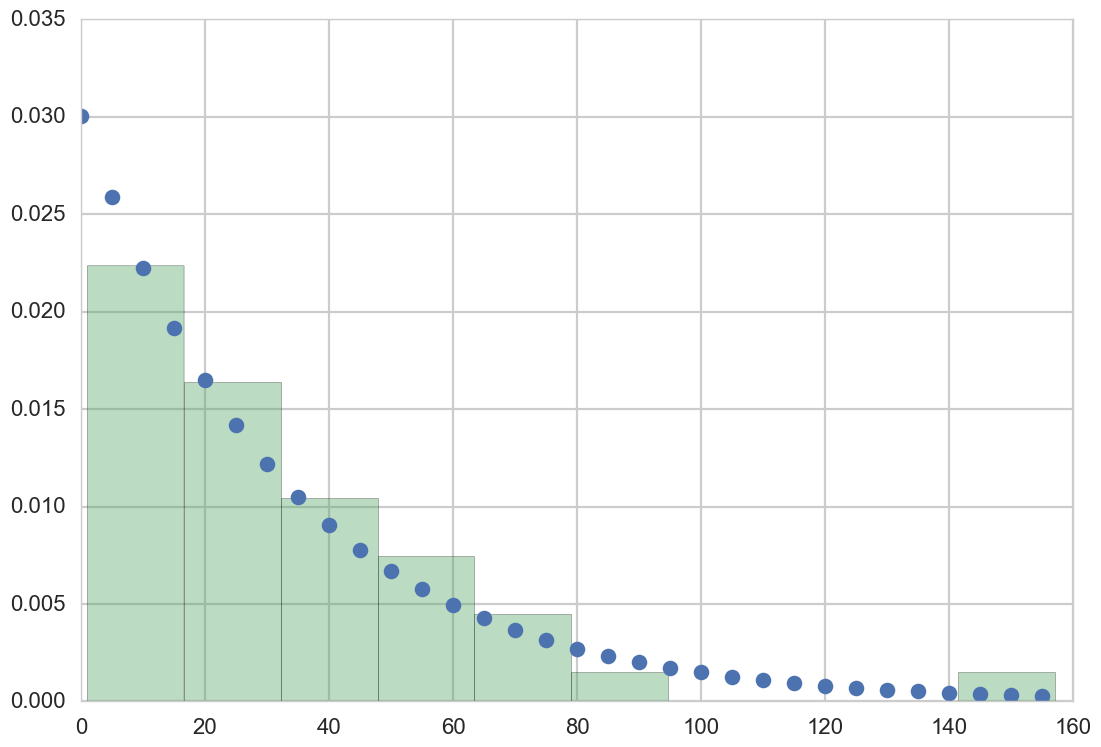

In [159]:
plot_scale = np.arange(0,160,5)
plt.plot(plot_scale, expon.pdf(plot_scale, scale = diff.mean()), 'o')
diff.hist(normed=True, alpha=0.4)


### Poisson Distribution

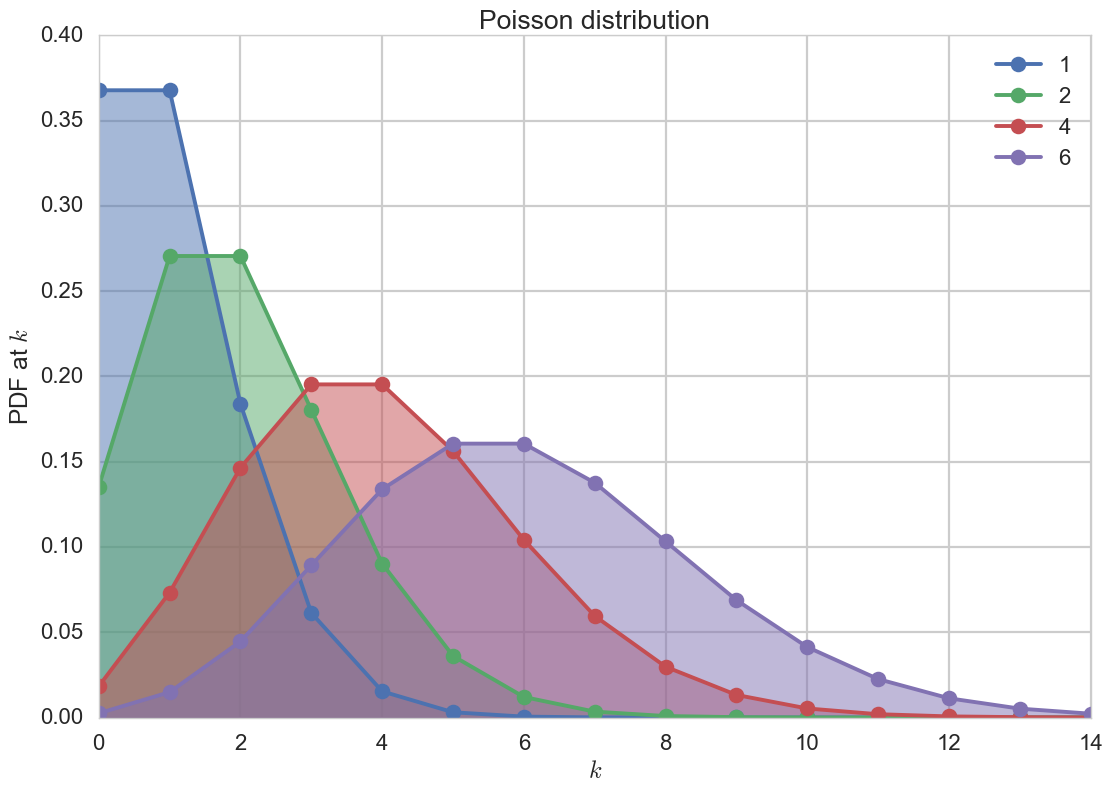

In [15]:
from scipy.stats import poisson
scale_p = np.arange(15)
for i, lambda_ in enumerate([1, 2, 4, 6]):
    plt.plot(scale_p, poisson.pmf(scale_p, lambda_), '-o', color = colors[i], label = lambda_)
    plt.fill_between(scale_p, poisson.pmf(scale_p, lambda_), alpha=0.5, color=colors[i])
    plt.legend()
plt.title("Poisson distribution")
plt.ylabel("PDF at $k$")
plt.xlabel("$k$");    

In [11]:
per_hours = baby.minutes // 60
birth_hours = baby.groupby(per_hours).minutes.count()
birth_hours

minutes
0     1
1     3
2     1
4     4
7     2
8     2
9     1
10    3
11    1
12    2
13    1
14    4
15    1
16    2
17    1
18    3
19    4
20    3
21    2
22    1
23    2
Name: minutes, dtype: int64

In [12]:
birth_hours.mean()

2.0952380952380953

In [18]:
plt.plot?

C:\Users\Seuphor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


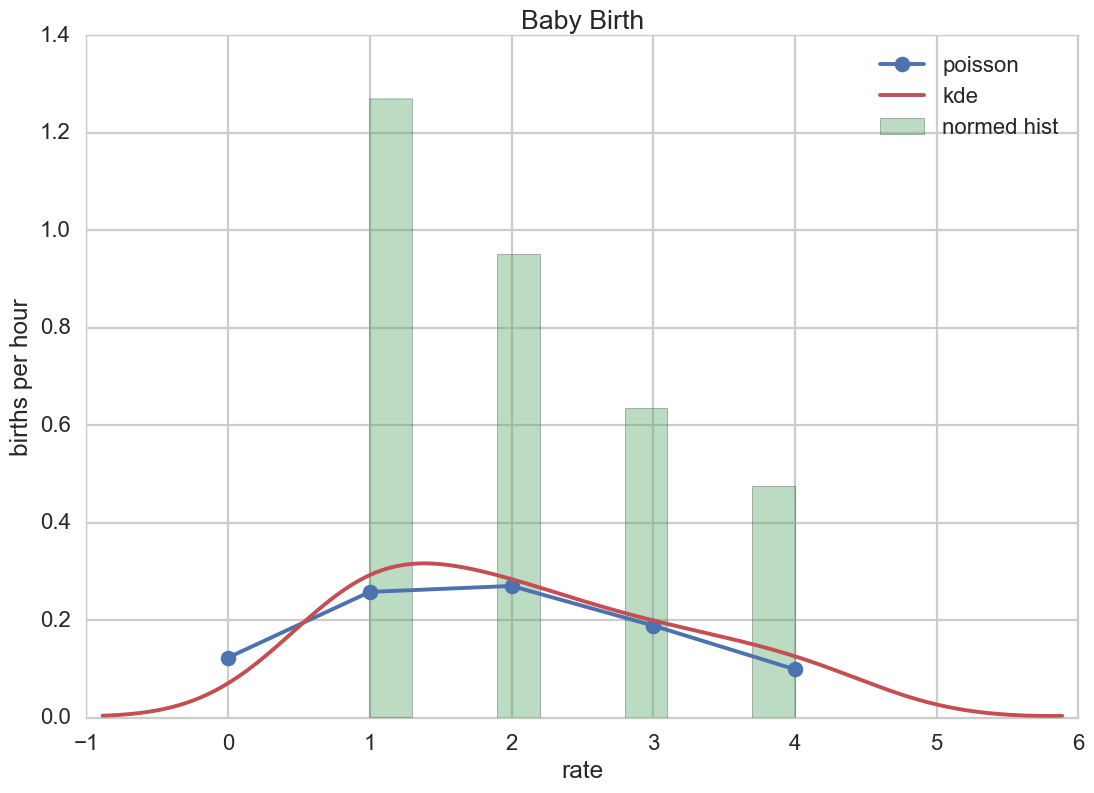

In [24]:
k_scale = np.arange(5)
plt.plot(k_scale, poisson.pmf(k_scale, birth_hours.mean()), '-o', label = 'poisson')
plt.hist(birth_hours, alpha=0.4, normed=True, label="normed hist")
sns.kdeplot(birth_hours, label='kde')
plt.title('Baby Birth')
plt.xlabel('rate')
plt.ylabel('births per hour')
plt.legend()

### Estimate lambda from large sample set

In [25]:
from scipy.stats.distributions import bernoulli
def throw_a_coin(n):
    brv = bernoulli(0.5)
    return brv.rvs(size=n)

In [51]:
def get_samples(n_sample, n_size):
    blank = np.zeros((n_sample, n_size), dtype=int)
    for i in range(n_sample):
        blank[i,:] = throw_a_coin(n_size)
    return np.mean(blank, axis=1)




In [75]:
sample_sizes = np.arange(1,1001,1)
means_sample = [get_samples(200, i) for i in sample_sizes]
means_sample_means = [np.mean(mean) for mean in means_sample]

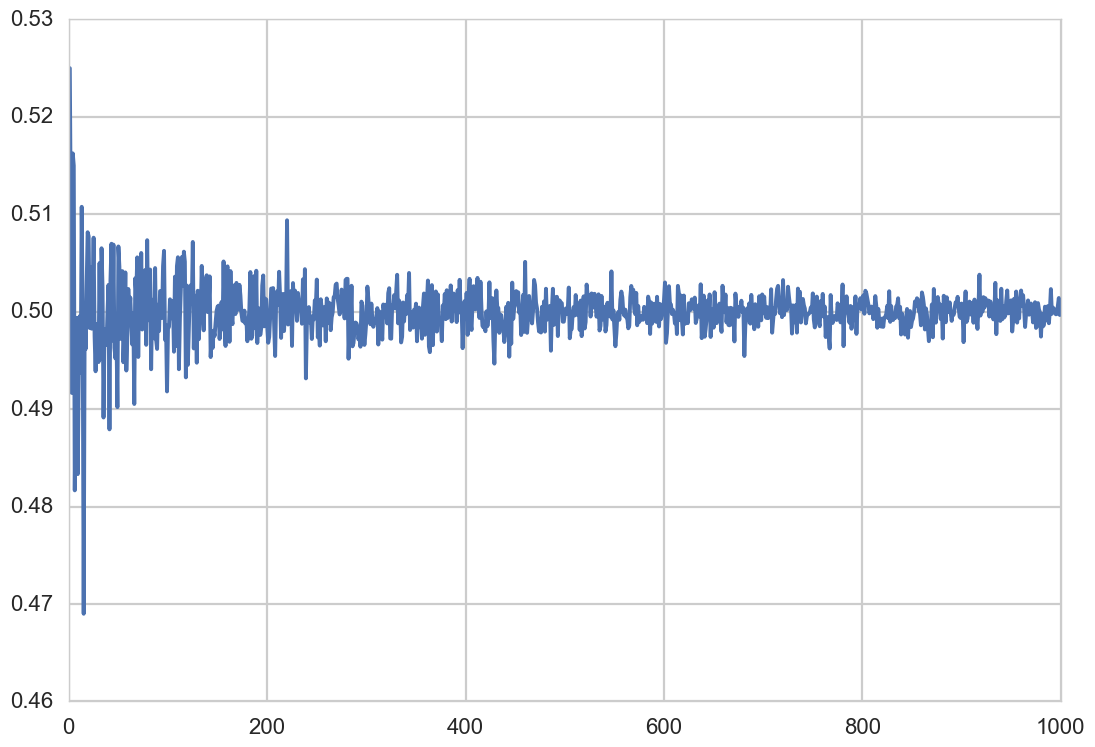

In [76]:
plt.plot(sample_sizes, means_sample_means)

In [104]:
n_samples = 1000
n_points = diff.shape[0]
bs_np = np.random.choice(diff, size=(n_samples, n_points))

C:\Users\Seuphor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


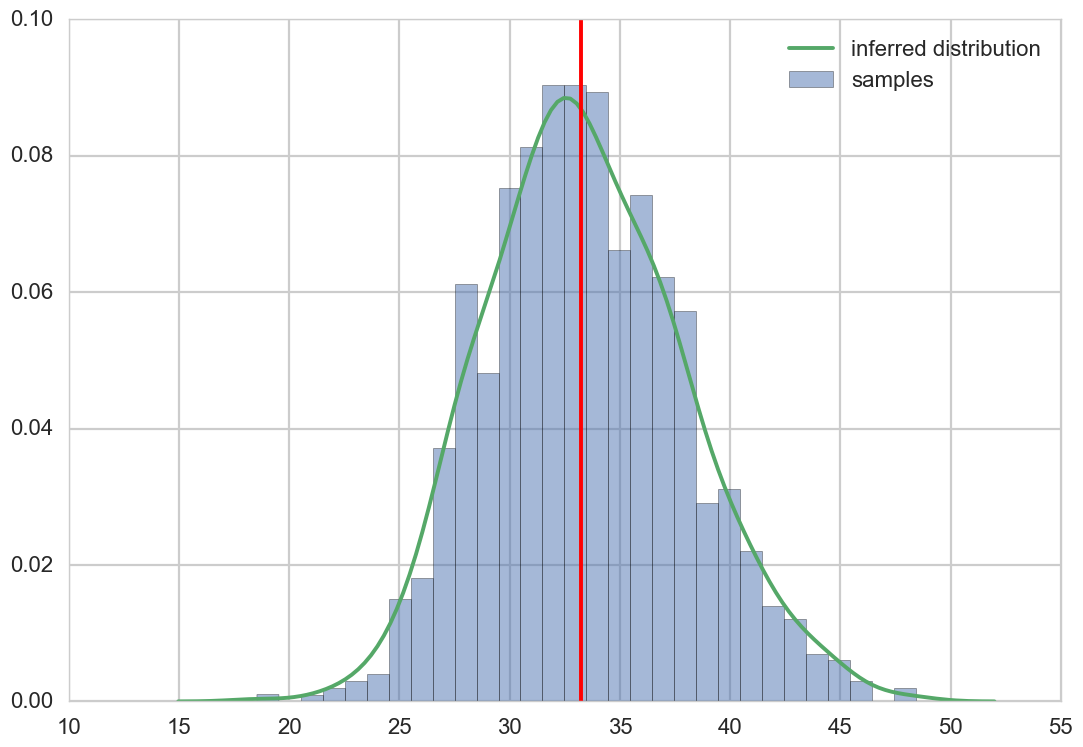

In [115]:
bs_mean = np.mean(bs_np, axis=1)
plt.hist(bs_mean, normed = True, bins = 30, label = 'samples', alpha = 0.5)
sns.kdeplot(bs_mean, label = 'inferred distribution')
plt.axvline(diff.mean(), color = 'r', label = 'our sample')

### Parametric Bootstrap

In [117]:
exp = expon(scale = diff.mean())
n_sample = 1000
n_point = diff.shape[0]
bs_par = exp.rvs(size = (n_sample, n_point))

C:\Users\Seuphor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


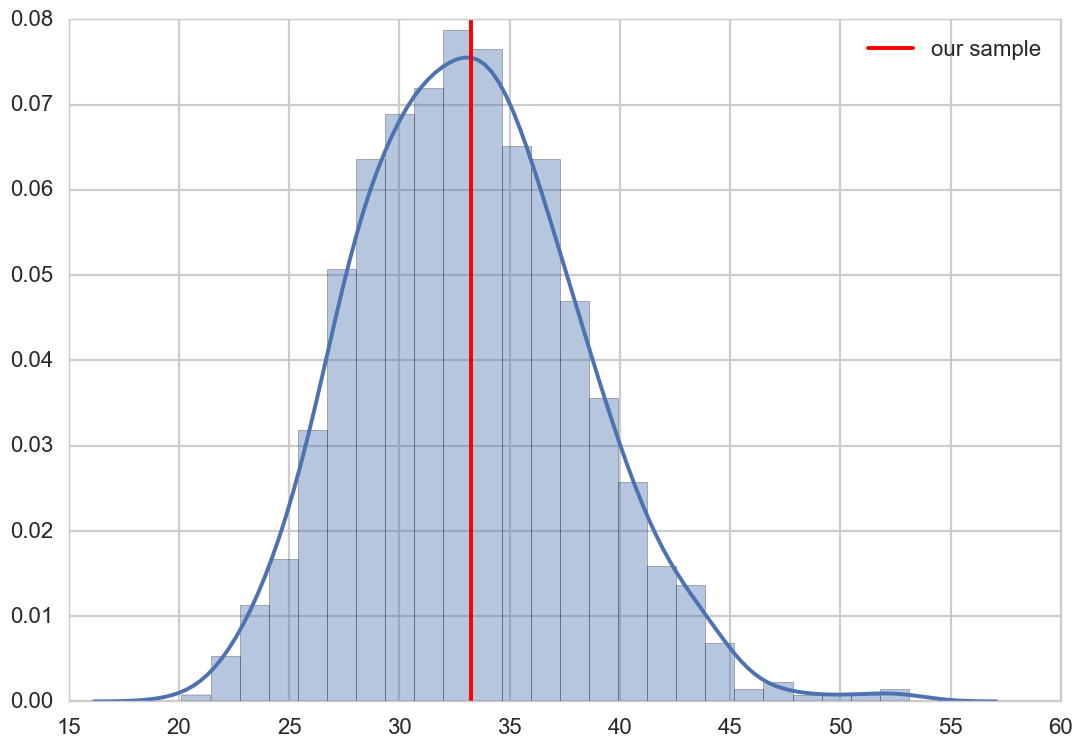

In [128]:
bs_par_mean = np.mean(bs_par, axis = 1)
sns.distplot(bs_par_mean)
plt.axvline(diff.mean(), color = 'r', label = 'our sample')
plt.legend()